# Experimento UCB

<a href="https://colab.research.google.com/github/ldaniel-hm/eml_k_bandit/blob/main/bandit_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparación del entorno


In [1]:
# Configurar el path para imports
import sys
import os

# Añadir el directorio k_brazos al path de Python
notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in globals() else os.getcwd()
k_brazos_dir = notebook_dir if 'k_brazos' in notebook_dir else os.path.join(notebook_dir, 'k_brazos')
if k_brazos_dir not in sys.path:
    sys.path.insert(0, k_brazos_dir)

print(f"Working directory: {os.getcwd()}")
print(f"Added to path: {k_brazos_dir}")

Working directory: c:\Users\raulra\Desktop\Master\SegundoCuatrimestre\ExtensionesML\Practicas\Codigo\EscuderoRodriguezSanchez\k_brazos
Added to path: c:\Users\raulra\Desktop\Master\SegundoCuatrimestre\ExtensionesML\Practicas\Codigo\EscuderoRodriguezSanchez\k_brazos


In [ ]:
#@title Importamos todas las clases y funciones
from src.algorithms.ucb1 import UCB1

import numpy as np
from typing import List

from src.arms import ArmNormal, ArmBinomial, ArmBernoulli, Bandit
from src.plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics

from k_brazos.src.utils import SEMILLA

from src.run_experiment import run_experiment

## Experimento

Vamos a empezar definiendo las variables de nuestro marco experimental para probar y comparar los algoritmos. En nuestro experimento, nuestro bandido tendrá 10 brazos, el algoritmo se ejecutará durante mil pasos y esta ejecución la repetiremos unas 500 veces. Los resultados obtenidos serán el promedio de las recompensas obtenidas en cada paso para cada una de las ejecuciones.

Para el caso del algoritmo UCB1, tenemos el parámetro c, que es el parámetro de ajuste que controla el grado de exploración. Para nuestros experimentos, probaremos el algoritmo UCB1 con 3 valores para esté parámetro, que serán 0.1, 1 y 5. Con los valores más bajos, el algoritmo tendrá una tendencia a la explotación, mientras que valores más altos tendrán una mayor tendencia a la exploración. El valor de 1 es el valor típico por defecto para este algoritmo.

In [3]:
# Parámetros del experimento
seed = 42
np.random.seed(SEMILLA)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Definir los algoritmos a comparar. En este caso son 3 algoritmos UCB con diferentes valores de c.
algorithms = [
    UCB1(k=k, c=0.1), # Valor con tendencia a la explotación
    UCB1(k=k, c=1.0), # Valor por defecto genérico
    UCB1(k=k, c=5.0)  # Valor con tendencia a la exploración
]

## Ejecución del experimento con distribución Normal

Vamos a empezar realizando el experimento utilizando brazos con una distribución normal.

In [4]:
# Creación del bandit
bandido = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandido)

brazo_optimo = bandido.optimal_arm
print(f"Optimal arm: {brazo_optimo + 1} with expected reward={bandido.get_expected_value(brazo_optimo)}")

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_normal, optimal_selections_normal = run_experiment(bandido, algorithms, steps, runs)

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


### Visualización de los resultados distribución Normal

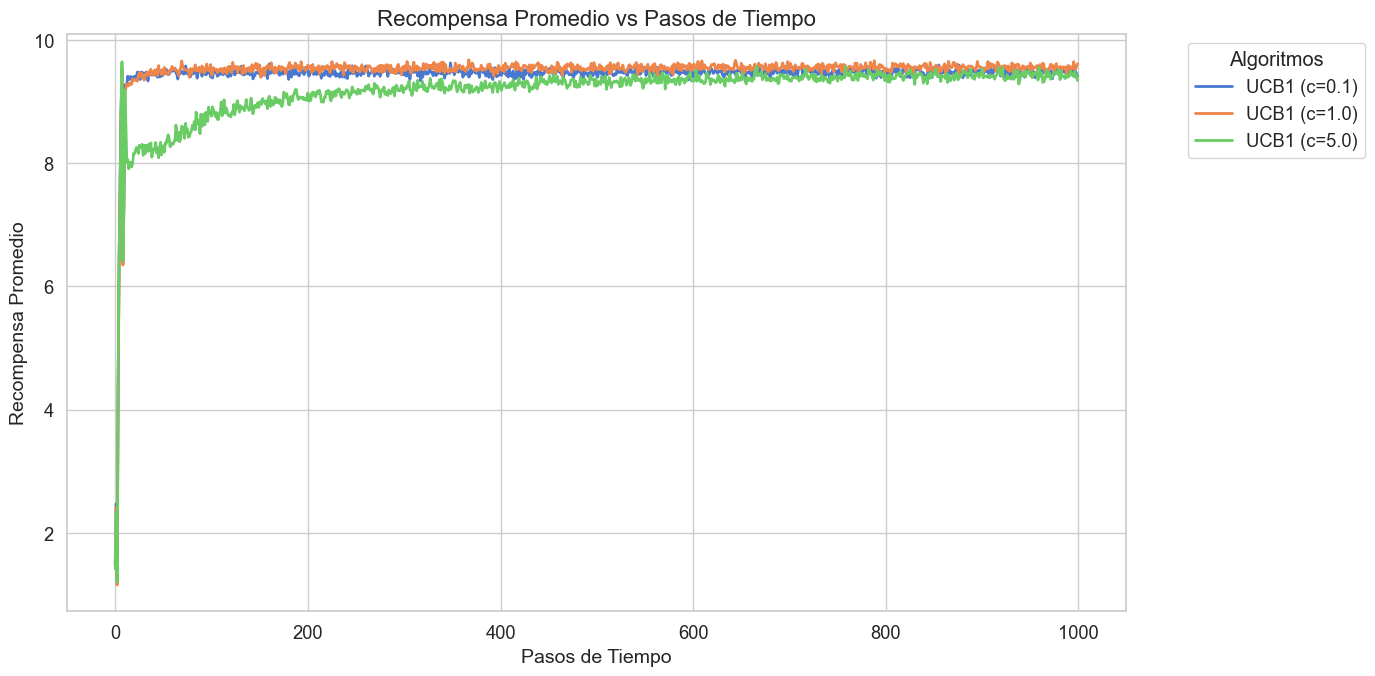

In [5]:
# Graficar los resultados
plot_average_rewards(steps, rewards_normal, algorithms)

### Análisis del Algoritmo UCB1 (Distribución Normal)

El gráfico muestra la evolución de la recompensa promedio a lo largo de 1000 pasos, comparando diferentes valores del parámetro (c).

* **Azul (c=0.1):** Este es el valor de c más centrado en la explotación. Sin embargo, ha conseguido encontrar bastante rápido un brazo que genera muy buenas recompensas y consigue mantenerse en el valor de recompensa esperado.

* **Naranja (c=1):** Este es el valor de c más típico, y es un valor más equilibrado en cuanto a exploración y explotación. En este caso, el algoritmo ha tardado unos cuantos pasos más en converger, pero los resultados son ligeramente mejores a los obtenidos por el algoritmo anterior.

* **Verde (c=5):** Este es el valor de c más centrado en la exploración. En este caso, tarda mucho más en converger, empezando a generar unos resultados decentes a partir del paso 400, y empezando a igualar los resultados del primer algoritmo a partir del paso 800.

---

In [6]:
print(f"optimal selections: {optimal_selections_normal}")

optimal selections: [[0.    0.    0.    ... 0.89  0.89  0.89 ]
 [0.    0.    0.    ... 0.996 0.996 0.996]
 [0.    0.    0.    ... 0.882 0.908 0.894]]


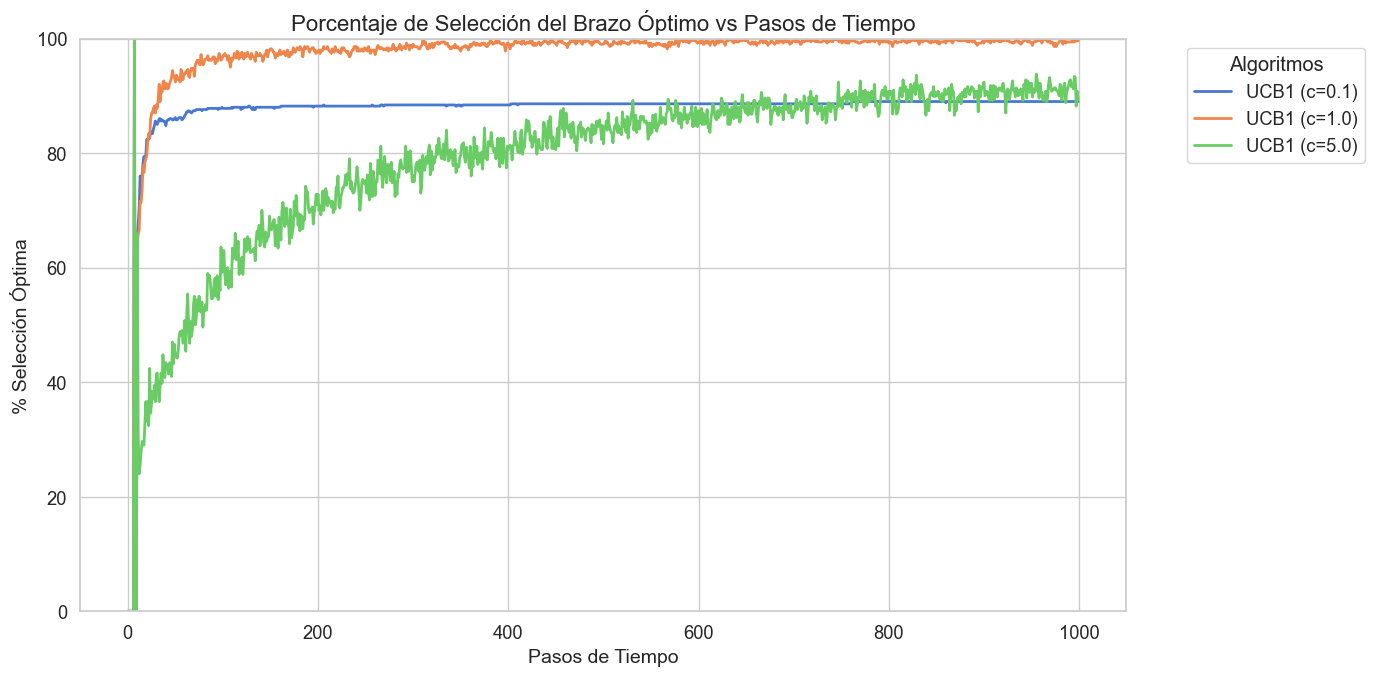

In [7]:
plot_optimal_selections(steps, optimal_selections_normal, algorithms)

### Análisis detallado de la selección óptima

El gráfico muestra la evolución del porcentaje de selección del brazo óptimo promedio a lo largo de 1000 pasos, comparando diferentes valores del parámetro (c)

* **Azul (c=0.1):** Este es el valor de c más centrado en la explotación. Aún así, consigue rápidamente encontrar un brazo con buenos resultados, y se queda cerca de un 90% de selección del brazo óptimo.

* **Naranja (c=1):** Este es el valor de c más típico, y es un valor más equilibrado en cuanto a exploración y explotación. En este caso podemos ver como alcanza los resultados obtenidos por el algoritmo anterior prácticamente a la vez, pero consigue mejorar incluso más y a partir del paso 400 consigue prácticamente un 100% de selección del brazo óptimo constante. Este algoritmo no ha sufrido penalización ninguna por centrarse más en la exploración y consigue mejores resultados.

* **Verde (c=5):** Este es el valor de c más centrado en la exploración. En este caso, podemos ver que el algoritmo tarda bastante en encontrar un buen brazo, y hasta no llegar al paso 600 no consigue encontrar un brazo que sea al menos equivalente al primer algoritmo, pero podemos apreciar que a partir del paso 800 obtiene en general mejores resultados que el primer algoritmo.

---

### Estadisticas de Ganancia VS Pérdida por Algoritmo

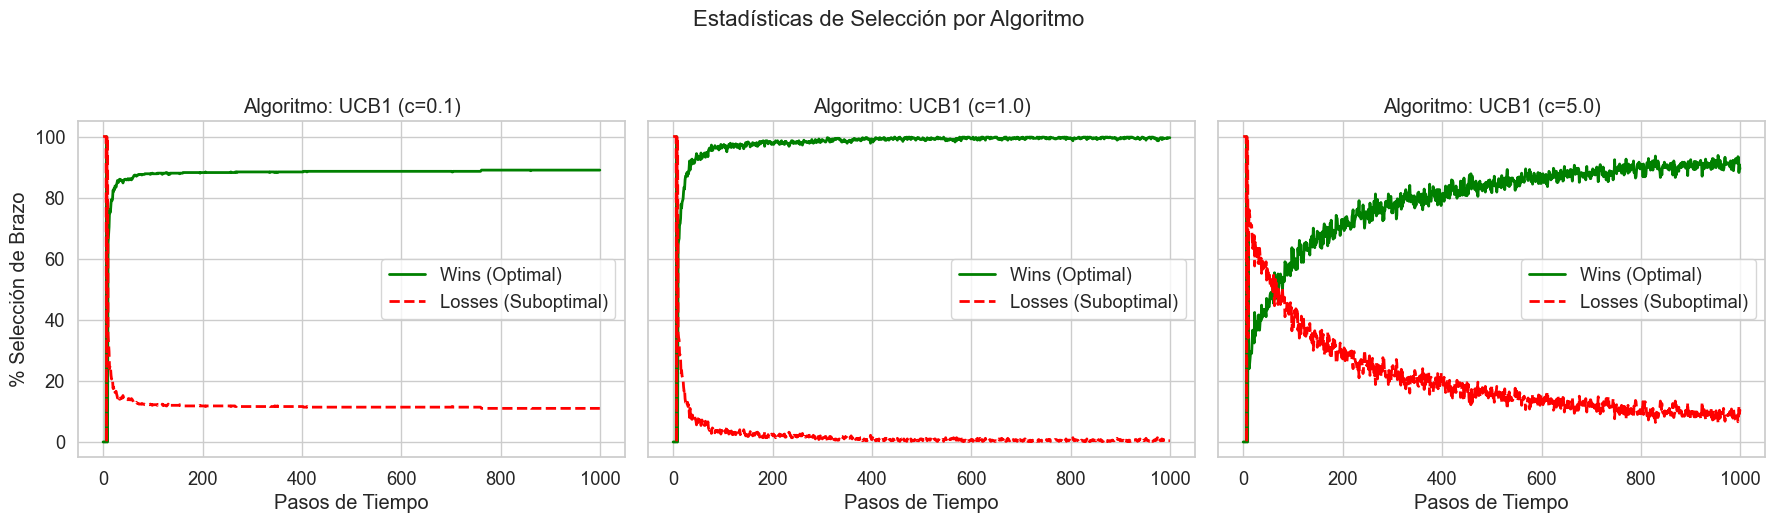

In [8]:
plot_arm_statistics(arm_stats_normal, algorithms)

---

## Ejecución del experimento con distribución Binomial

Ahora vamos a probar los algoritmos con la distribución binomial.

In [9]:
# Creación del bandit
bandido = Bandit(arms=ArmBinomial.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandido)

brazo_optimo = bandido.optimal_arm
print(f"Optimal arm: {brazo_optimo + 1} with expected reward={bandido.get_expected_value(brazo_optimo)}")

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_binomial, optimal_selections_binomial = run_experiment(bandido, algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(n=10, p=0.66), ArmBinomial(n=10, p=0.03), ArmBinomial(n=10, p=0.70), ArmBinomial(n=10, p=0.10), ArmBinomial(n=10, p=0.13), ArmBinomial(n=10, p=0.11), ArmBinomial(n=10, p=0.53), ArmBinomial(n=10, p=0.41), ArmBinomial(n=10, p=0.81), ArmBinomial(n=10, p=0.73)
Optimal arm: 9 with expected reward=8.057161835465395


### Visualización de los resultados del experimento Binomial

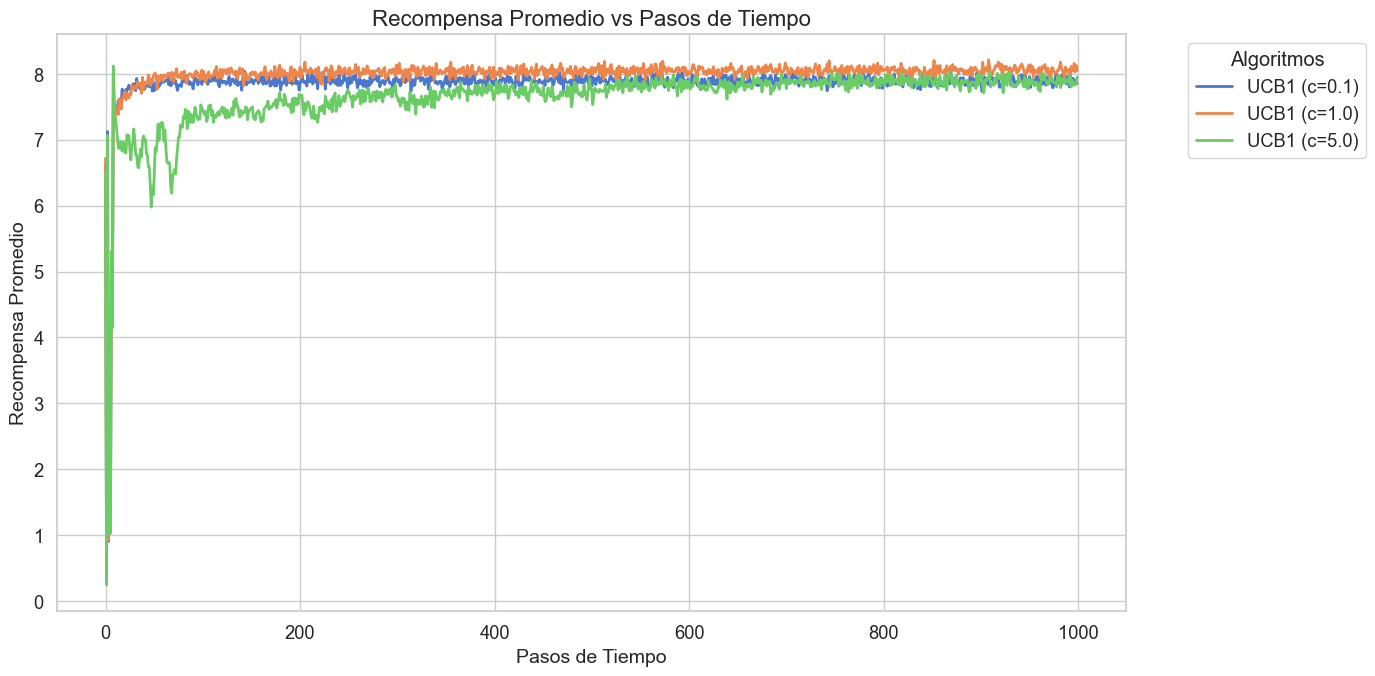

In [10]:
# Graficar los resultados
plot_average_rewards(steps, rewards_binomial, algorithms)
# plot_optimal_selections(steps, optimal_selections_binomial, algorithms)

### Análisis del Algoritmo UCB1 (Distribución Binomial)

El gráfico muestra la evolución de la recompensa promedio a lo largo de 1000 pasos, comparando diferentes valores del parámetro (c).

* **Azul (c=0.1):** Este es el valor de c más centrado en la explotación. Sin embargo, ha conseguido encontrar bastante rápido un brazo que genera muy buenas recompensas y consigue mantenerse en el valor de recompensa esperado.

* **Naranja (c=1):** Este es el valor de c más típico, y es un valor más equilibrado en cuanto a exploración y explotación. En este caso, el algoritmo ha tardado unos cuantos pasos más en converger, pero los resultados son ligeramente mejores a los obtenidos por el algoritmo anterior.

* **Verde (c=5):** Este es el valor de c más centrado en la exploración. En este caso, tarda mucho más en converger, empezando a generar unos resultados decentes a partir del paso 400, y empezando a igualar los resultados del primer algoritmo a partir del paso 600.

---

In [11]:
print(f"optimal selections: {optimal_selections_binomial}")

optimal selections: [[0.    0.    0.    ... 0.814 0.814 0.814]
 [0.    0.    0.    ... 0.998 0.996 0.996]
 [0.    0.    0.    ... 0.86  0.87  0.872]]


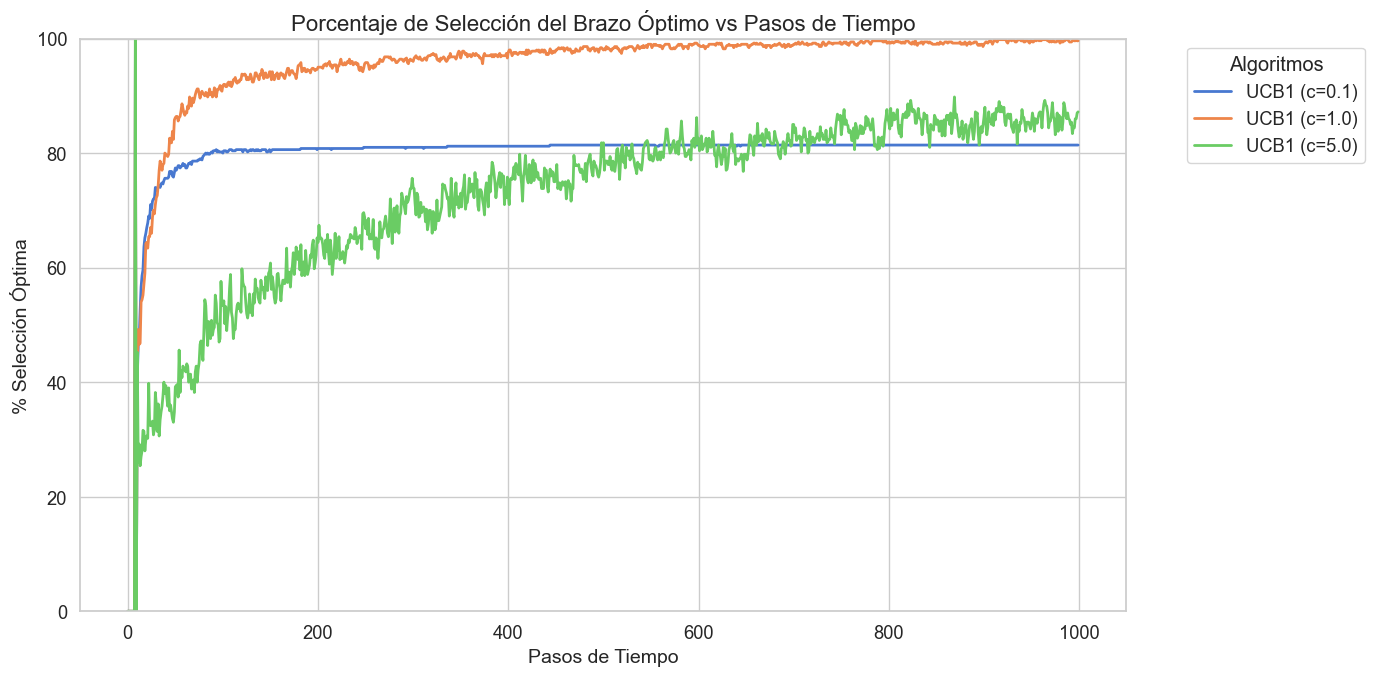

In [12]:
plot_optimal_selections(steps, optimal_selections_binomial, algorithms)

### Análisis detallado de la selección óptima

El gráfico muestra la evolución del porcentaje de selección del brazo óptimo promedio a lo largo de 1000 pasos, comparando diferentes valores del parámetro (c)

* **Azul (c=0.1):** Este es el valor de c más centrado en la explotación. Aún así, consigue rápidamente encontrar un brazo con buenos resultados, y se queda cerca de un 90% de selección del brazo óptimo.

* **Naranja (c=1):** Este es el valor de c más típico, y es un valor más equilibrado en cuanto a exploración y explotación. En este caso podemos ver como alcanza los resultados obtenidos por el algoritmo anterior prácticamente a la vez, pero consigue mejorar incluso más y a partir del paso 200 consigue prácticamente un 100% de selección del brazo óptimo constante. Este algoritmo no ha sufrido penalización ninguna por centrarse más en la exploración y consigue mejores resultados.

* **Verde (c=5):** Este es el valor de c más centrado en la exploración. En este caso, podemos ver que el algoritmo tarda bastante en encontrar un buen brazo, y hasta no llegar al paso 500 no consigue encontrar un brazo que sea al menos equivalente al primer algoritmo, pero podemos apreciar que a partir del paso 600 obtiene en general mejores resultados que el primer algoritmo.

---


### Estadisticas de Ganancia VS Pérdida por Algoritmo

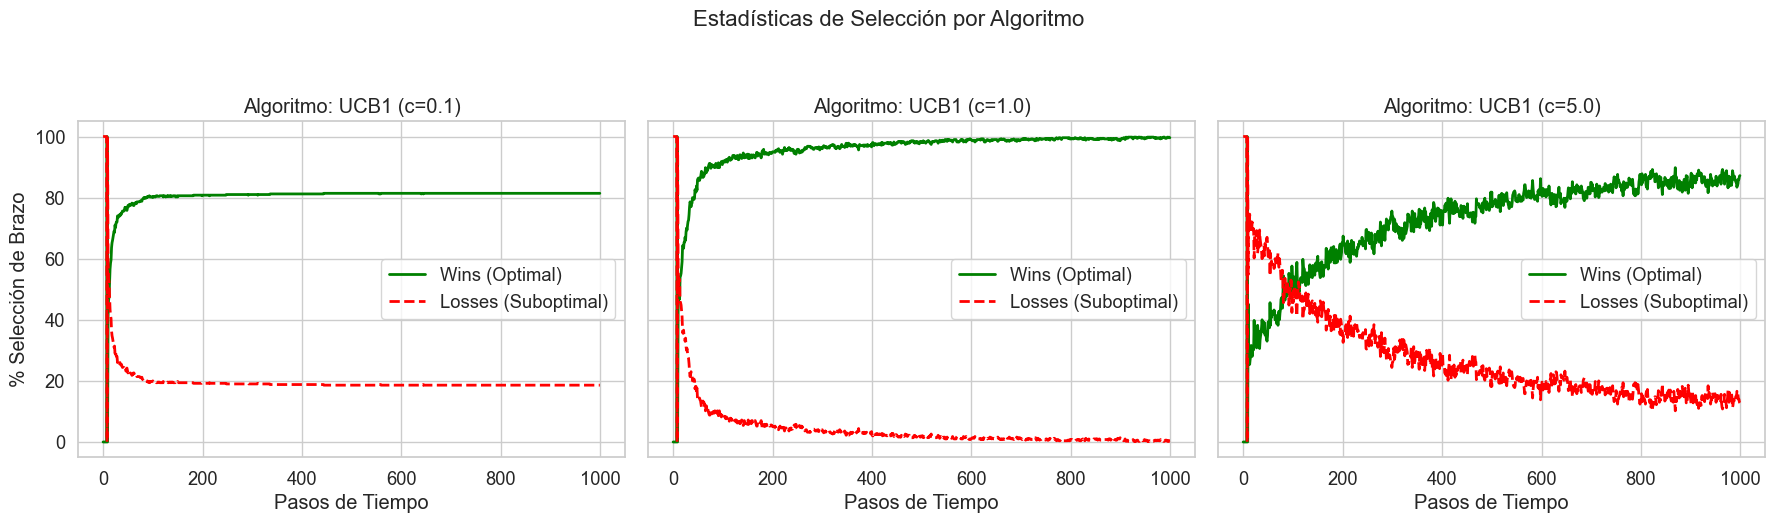

In [13]:
plot_arm_statistics(arm_stats_binomial, algorithms)

---

## Ejecución del experimento con distribución Bernoulli

Por último, vamos a probar los algoritmos con la distribución de Bernoulli.

In [14]:
# Creación del bandit
bandido = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandido)

brazo_optimo = bandido.optimal_arm
print(f"Optimal arm: {brazo_optimo + 1} with expected reward={bandido.get_expected_value(brazo_optimo)}")

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_bernoulli, optimal_selections_bernoulli = run_experiment(bandido, algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.72), ArmBernoulli(p=0.42), ArmBernoulli(p=0.20), ArmBernoulli(p=0.10), ArmBernoulli(p=0.70), ArmBernoulli(p=0.78), ArmBernoulli(p=0.61), ArmBernoulli(p=0.95), ArmBernoulli(p=0.15), ArmBernoulli(p=0.30)
Optimal arm: 8 with expected reward=0.9519720396531723


### Visualización de los resultados del experimento Bernoulli

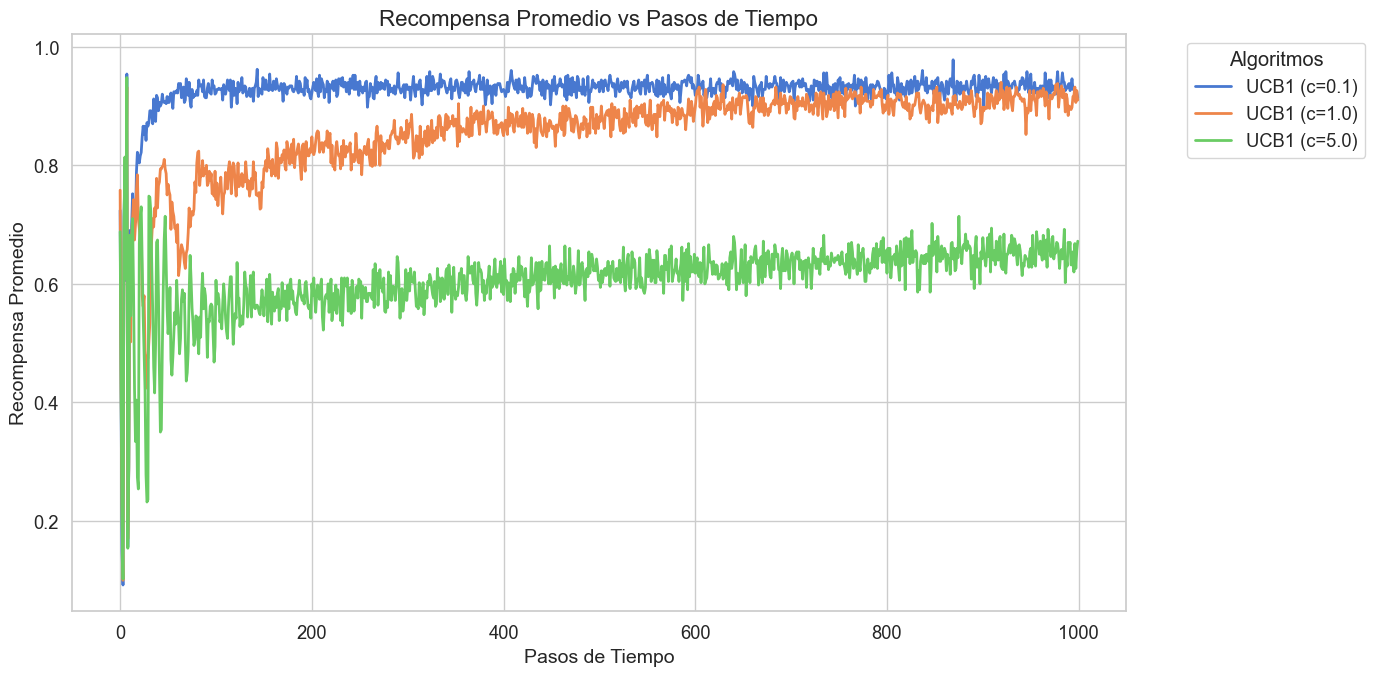

In [15]:
# Graficar los resultados
plot_average_rewards(steps, rewards_bernoulli, algorithms)
# plot_optimal_selections(steps, optimal_selections_bernoulli, algorithms)

### Análisis del Algoritmo UCB1 (Distribución Bernoulli)

El gráfico muestra la evolución de la recompensa promedio a lo largo de 1000 pasos, comparando diferentes valores del parámetro (c).

* **Azul (c=0.1):** Este es el valor de c más centrado en la explotación. Sin embargo, ha conseguido encontrar bastante rápido un brazo que genera muy buenas recompensas y consigue mantenerse en el valor de recompensa esperado.

* **Naranja (c=1):** Este es el valor de c más típico, y es un valor más equilibrado en cuanto a exploración y explotación. En este caso, el algoritmo ha tardado bastante más en converger, y podemos ver que necesitamos llegar hasta el paso 500 para conseguir unos resultados similares a los del primer algoritmo.

* **Verde (c=5):** Este es el valor de c más centrado en la exploración. En este caso, podemos ver que la exploración excesiva hace que los resultados sean muy malos, mejorando poco a poco con el paso del tiempo, pero ni siquiera llegando a unos resultados decentes en el paso 1000.

---

In [16]:
print(f"optimal selections: {optimal_selections_bernoulli}")

optimal selections: [[0.    0.    0.    ... 0.902 0.902 0.902]
 [0.    0.    0.    ... 0.852 0.85  0.858]
 [0.    0.    0.    ... 0.262 0.26  0.216]]


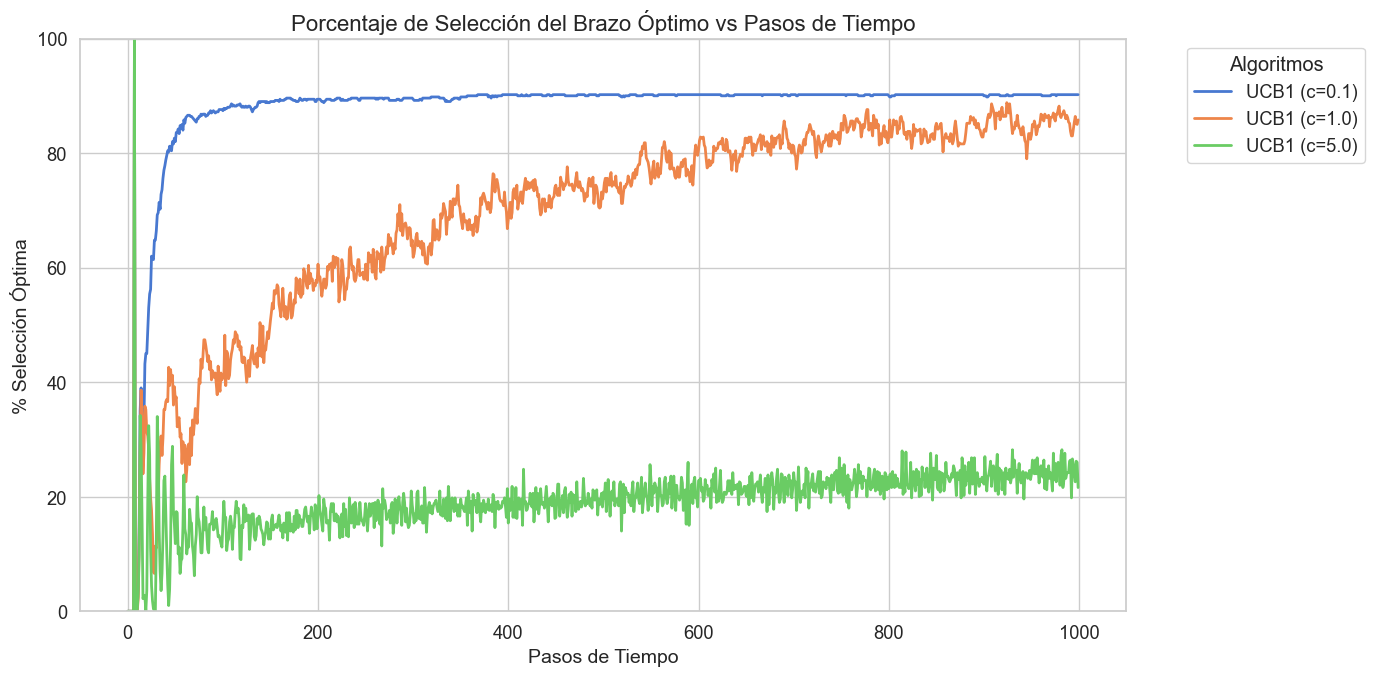

In [17]:
plot_optimal_selections(steps, optimal_selections_bernoulli, algorithms)

### Análisis detallado de la selección óptima

El gráfico muestra la evolución del porcentaje de selección del brazo óptimo promedio a lo largo de 1000 pasos, comparando diferentes valores del parámetro (c)

* **Azul (c=0.1):** Este es el valor de c más centrado en la explotación. Aún así, consigue rápidamente encontrar un brazo con buenos resultados, y se queda por encima de un 90% de selección del brazo óptimo.

* **Naranja (c=1):** Este es el valor de c más típico, y es un valor más equilibrado en cuanto a exploración y explotación. En este caso podemos tarda bastante más que el algoritmo anterior en converger, y hasta el paso 500 no consigue obtener el mismo porcentaje que el algoritmo anterior. Aún así, a partir de ese paso los resultados no son tan consistentes como en el algoritmo anterior, teniendo pasos con porcentajes mejores y otros con peores.

* **Verde (c=5):** Este es el valor de c más centrado en la exploración. En este caso, podemos ver que la exploración excesiva hace que los resultados sean muy malos, mejorando poco a poco con el paso del tiempo, pero llegando solamente al 40% en el paso 1000.

---

### Estadisticas de Ganancia VS Pérdida por Algoritmo

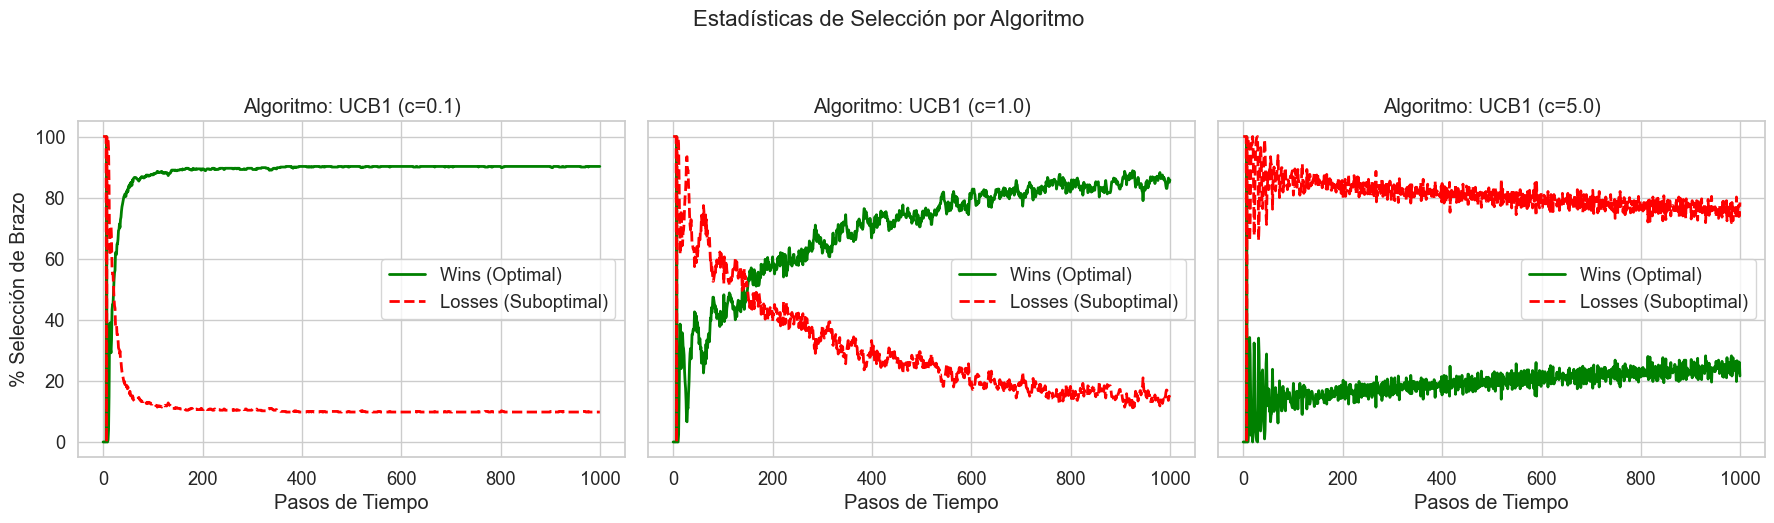

In [18]:
plot_arm_statistics(arm_stats_bernoulli, algorithms)

## Conclusiones

Hemos estudiado un  **experimento de toma de decisiones secuenciales**, modelado con un **Multi-Armed Bandit (MAB)**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **UCB-1** equilibra la exploración y la explotación con el parámetro c:
* **Azul (c=0.1):** A pesar de la poca exploración, consigue unos resultados muy buenos rápidamente, y lo podemos apreciar en las 3 distribuciones.
* **Naranja (c=1):** Para el caso de la distribución normal y binomial, podemos ver que la exploración extra con respecto al primer algoritmo no hace que tarde mucho más en converger y en general obtenemos mejores resultados. Para el caso de la distribución de Bernoulli, si podemos apreciar que tarda más en converger que el primer algoritmo sin conseguir unos resultados mejores, por lo que merece más la pena una mayor explotación.
* **Verde (c=5):** En este caso, para las 3 distribuciones, podemos apreciar que la exploración está siendo excesiva y no se consiguen buenos resultados, o se tarda mucho en obtenerlos.

#### **2. Convergencia de los algoritmos**
Los algoritmos con mayor explotación (c=0.1,1 frente a c=5) alcanzan recompensas altas bastante rápido. Esto se debe a que la excesiva exploración hace que el bandido elija brazos que no generan buenas recompensas y tarde bastante más en tiempo en encontrar el brazo que si las puede generar. Por ello, un balance entre exploración y explotación es importante, pero podemos centrarnos más en la explotación.


#### **3. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **c=1** nos permite encontrar brazos que generen buenas recompensas y aún así explotar esos brazos lo suficiente como para mantener buenos resultados.
- **Una excesiva exploración (c=5)** lleva a un desempeño deficiente, ya que el agente puede quedarse probando brazos continuamente en vez de centrarse en el que genere buenos resultados.

En conclusión, **los gráficos muestran como un nivel adecuado de exploración puede mejorar los resultados generales, pero debemos centrarnos en la explotación para evitar tardar demasiado en centrarnos en el brazo que nos genere mejores resultados**.